# 实验四：基于自动编码器的手写数字生成

## 简介

自动编码器是一种数据的压缩算法，其中数据的压缩（编码）和解压缩（解码）函数是

1. 数据相关的；
2. 有损的；
3. 从样本中自动学习的。

在大部分提到自动编码器的场合，压缩和解压缩的函数是通过神经网络实现的。



1. **自动编码器是数据相关的（data-specific 或 data-dependent）**

    这意味着自动编码器只能压缩那些**与训练数据类似的数据**。自编码器与一般的压缩算法，如 `MPEG-2`，`MP3` 等压缩算法不同，一般的通用算法可以进行图像、音频或各种多媒体进行通用压缩，而不用考虑这些数据到底是哪种数据。比如，如果使用自动编码器进行压缩，而且前期的训练数据只包含人脸，那么在压缩别的图片（比如树木）时，性能就会很差，因为它学习到的特征是与人脸相关的。

2. **自动编码器是有损的**

    意思是解压缩的输出与原来的输入相比是**有损、退化**的，就像 `MP3`，`JPEG` 等压缩算法一样。这与无损压缩算法，如*熵编码*或是*霍夫曼编码*不同。

3. **自动编码器是从数据样本中自动学习的**

    这意味着很容易通过训练数据训练出一种特定的编码器，而**不需要引入外界监督信息或通过人工制定规则来构造自动编码器**。

搭建一个自动编码器需要完成下面三样工作：
1. 搭建编码器；
2. 搭建解码器；
3. 设定一个损失函数，用以衡量由于压缩而损失掉的信息。

编码器和解码器一般都是参数化的方程，并关于损失函数可导。在深度学习中，我们就可以使用神经网络来做这件事。编码器和解码器的可学习参数可以通过最小化损失函数而优化，例如 [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html)。

## 自动编码器的基本结构

自动编码器由编码器和解码器组成。编码器把输入转换成隐变量，解码器再从隐变量重构输入。


### 自动编码器的编码过程

对于输入 $\bf{x}$，我们使用一个非线性映射 $\bf{E}$ 将输入转换成低维隐变量 $\bf{z}$.

$$
\bf{z} = \text{E}\left( \bf{x} \right)
$$

### 自动编码器的解码过程

我们使用另一个非线性映射 $\bf{E}$ 将隐变量 $\bf{z}$ 转换回 $\hat{\bf{x}}$.

$$
\hat{\bf{x}} = \text{D}\left( \bf{z} \right)
$$


最终，我们得到了自动编码器的基本范式：

$$
\hat{\bf{x}} = \text{D}\left( \text{E}\left( \bf{x} \right) \right), \\
\mathrm{minimize}\;\; d\left( \bf{x}, \hat{\bf{x}} \right).
$$

其中，$d$ 用来衡量 $\bf{x}$ 和 $\hat{\bf{x}}$ 之间的差距，通常作为损失函数进行优化；$E$ 和 $D$ 通常使用神经网络实现。


**下面，我们通过一步步搭建各个组件，来完成自动编码器的手写数字生成。**


## 搭建一个自动编码器

### 前期准备工作

在搭建自动编码器之前，我们需要弄清楚输入与输出。

我们使用 **MNIST** 数据集作为训练数据。**MNIST** 数据集（Mixed National Institute of Standards and Technology database）是美国国家标准与技术研究院收集整理的大型手写数字数据库,包含 $60,000$ 条训练数据以及 $10,000$ 条测试数据。

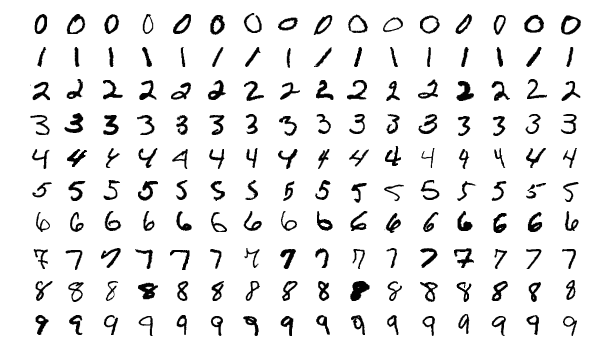

这些手写数字均为灰度图像（单通道），分辨率为 $28 \times 28$。

---
下面，我们先初始化环境并导入所需 Python 库。

### **请注意**

每个单元格都需要点击上方的 “运行” 按钮来执行。在执行过程中，如果单元格左侧显示为 “✶”，说明此单元格还没执行完。这时请不要执行后续的单元格。

In [1]:
import sys
import os
%matplotlib inline
import math

import torch
from torch import nn
import random
import torch.nn.functional as F

import torchvision

from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython import display
from ipywidgets import interact, widgets

import numpy as np

rcParams['font.sans-serif'] = ['simhei']
rcParams['axes.unicode_minus'] = False

print("Succecfully import all libs!")
print(f"PyTorch version: {torch.__version__}")
def YOU_NEED_IMPLEMENT():
    raise NotImplementedError("You have not implement the code!")

d:\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'D:\Python\Python310\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Succecfully import all libs!
PyTorch version: 2.0.1+cpu


---
### **下载所需的数据集文件**

这节课使用的压缩包包含数据集文件夹和这个 `notebook`，请把他们全部解压。


现在的目录结构如下：

```
|- 📁.
|
|- 📃AutoEncoder.ipynb （现在打开的文件）
|
|- 📁MNIST
|  |
|  |- 📁raw
|  |  |
|  |  |- 📦train-images-idx3-ubyte.gz
|  |  |- 📦train-labels-idx1-ubyte.gz
|  |  |- 📦t10k-images-idx3-ubyte.gz
|  |  |- 📦t10k-labels-idx1-ubyte.gz
|  |  |=
|  |=
|
|- 📁cifar-10-batches-py
|  |
|  |- 📦data_batch_1
|  |- 📦data_batch_2
|  |- 📦data_batch_3
|  |- 📦data_batch_4
|  |- 📦data_batch_5
|  |- 📦test_batch
|  |=
|=

```

请检查 “`MNIST`” 和 “`cifar-10-batches-py`” 文件夹📁下的文件是否存在。

In [2]:
mnistTraining = torchvision.datasets.MNIST("./", train=True, download=True)
mnistTest     = torchvision.datasets.MNIST("./", train=False, download=True)

100.0%


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100.0%


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100.0%


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100.0%

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



我们试试随机显示出 `mnistTraining` 中的一张手写数字和它的真实标签。

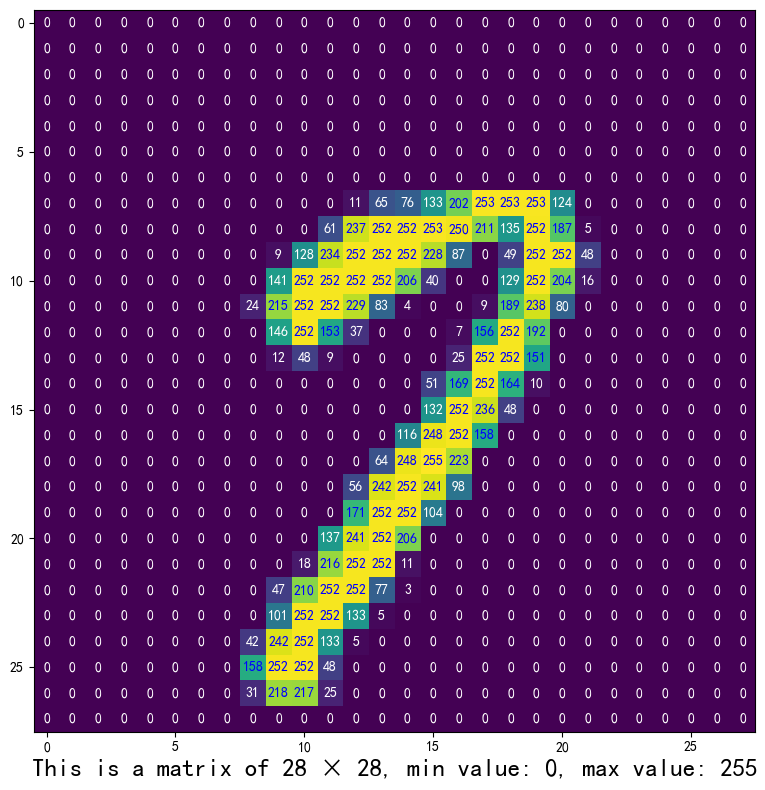

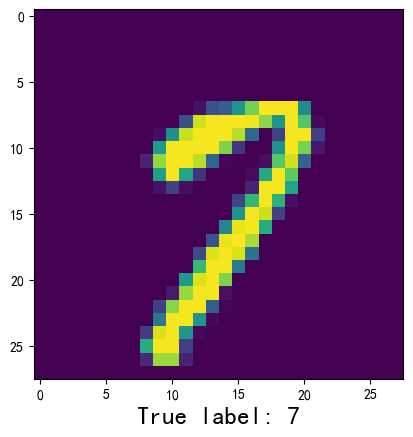

In [3]:
######### FOR VISUALIZATION, DO NOT CHANGE #########

import random

idx = random.randint(0, len(mnistTraining))

number, label = mnistTraining[idx]

number = np.array(number)

fig = plt.figure(figsize=(8,8), facecolor='w', edgecolor='k')

plt.imshow(number)

h, w = number.shape
for i in range(h):
    for j in range(w):
        plt.text(j, i, number[i, j], ha="center", va="center", color="w" if number[i, j] < 150 else "b")

plt.xlabel(f"This is a matrix of {w} × {h}, min value: {number.min()}, max value: {number.max()}", size=18)

plt.tight_layout()
plt.show()

plt.xlabel(f"True label: {label}", size=18)
plt.imshow(number)
plt.show()

######### FOR VISUALIZATION, DO NOT CHANGE #########

---
可以看出，`MNIST` 数据集中的手写数字分辨率为 `28*28`，通道数为 `1`，像素取值范围在 `0 ~ 255` 之间（`uint8`）。


接下来，我们准备必须的数据读取以及预处理函数，这些都已经为你写好。

In [4]:
################# DO NOT CHANGE #################
from torchvision import transforms as T

mnistTransforms = T.Compose([
    T.ToTensor(),
])

mnistTraining = torchvision.datasets.MNIST("./", train=True, download=True, transform=mnistTransforms)
mnistTest     = torchvision.datasets.MNIST("./", train=False, download=True, transform=mnistTransforms)

通过之前的课程，你应该可以知道，在实际训练网络时，我们会指定 `batch_size`，通过读取数据集，我们会得到：

* `x`：训练图像，维度为 `[batch_size, 1, 28, 28]`；
* `y`：标签，**我们不用这个数据**，自编码器是无监督学习方式。

因此，我们的网络接收 `[batch_size, 1, 28, 28]`，**经过编码器和解码器的变换后，还是得到 `[batch_size, 1, 28, 28]` 的输出**。
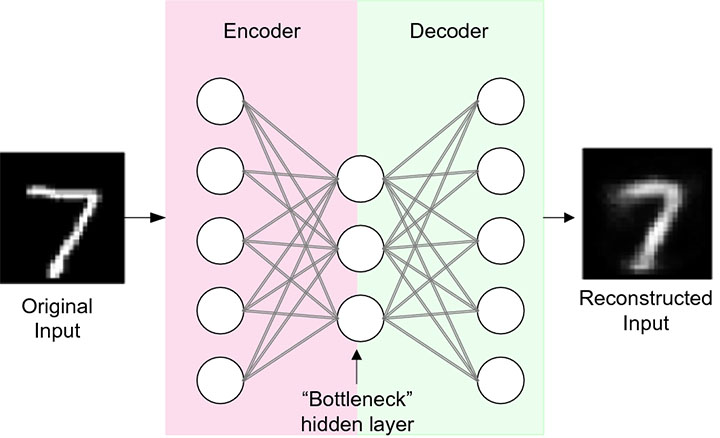

## 搭建一个编码器

现在，自动编码器的输入和输出已经确定，是一个 `[28, 28]` 的矩阵，在一般的图像处理操作中，我们会首先把像素的 `uint8` 值线性变换成 `0 ~ 1` 之间的浮点数再输入自动编码器。因此输入 $\bf{x}$ 为：
$$
\bf{x} \in \mathbb{R}^{28 \times 28}, \; \forall \bf{x}_{ij} \in \bf{x}, \; 0 \leq \bf{x}_{ij} \leq 1
$$

我们现在定义一个具有三个线性层，使用 `ReLU` 作为激活函数，再使用 `BatchNorm1d` 进行归一化处理的编码器 `Encoder`，输出隐变量 `z`（即 $\bf{z} = \bf{E}\left(\bf{x}\right)$）:

In [5]:
# Encoder
class Encoder(nn.Module):
    """ Vanilla encoder with 3 fc layers 
    Args:
            dIn (int): Dim of input, if `x.shape = [N, C, H, W]`, then `dIn = C*H*W`
        dHidden (int): Dim of intermediate FCs.
             dZ (int): Dim of z.
             
    Inputs:
        x (torch.FloatTensor): [N, 1, 28, 28]. Input images.
        
    Outputs:
        torch.FloatTensor: [N, dZ]. Latent variable z.
    """
    def __init__(self, dIn: int, dHidden: int, dZ: int):
        super().__init__()
        # [fc -> relu -> bn] * 2 -> fc 
        self._net = nn.Sequential(
            # Convert [N, C, H, W] to [N, C*H*W]
            nn.Flatten(),
            nn.Linear(dIn, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dZ)
        )
        
    def forward(self, x):
        return self._net(x)

这里，我们传入输入维度 `dIn`，隐藏层维度 `dHidden` 和隐变量维度 `dZ`，假如我们使用
```
encoder = Encoder(784, 200, 20)
```
初始化 Encoder，那么如果输入一组 5 个手写数字（`x.shape: [5, 1, 28, 28]`），那么他就会先被 [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) 变形为 `[5, 784]`，然后经过三个线性层输出维度为 `[5, 20]` 的隐变量 `z`。

In [6]:
encoder = Encoder(784, 200, 20)
x = torch.rand(5, 1, 28, 28)
# x -> [5, 784] -> [5, 200] ... -> [5, 20] = z
z = encoder(x)
print("Shape of \"z\":", list(z.shape))

Shape of "z": [5, 20]


## 搭建一个解码器

类似地，我们再搭建一个包含三个线性层的解码器 `Decoder`，把 $\bf{z}$ 还原为 $\hat{\bf{x}}$。

In [7]:
# Encoder
class Decoder(nn.Module):
    """ Vanilla decoder with 3 fc layers 
    Args:
             dZ (int): Dim of z.
        dHidden (int): Dim of intermediate FCs.
             hw (int): Height/width of x.
        channel (int): Channel num of x.
             
    Inputs:
        z (torch.FloatTensor): [N, dZ]. Input latent variable z.
        
    Outputs:
        torch.FloatTensor: [N, channel, hw, hw]. xHat, restored x.
    """
    def __init__(self, dZ: int, dHidden: int, hw: int, channel: int):
        super().__init__()
        # [fc -> relu -> bn] * 2 -> fc 
        self._net = nn.Sequential(
            nn.Linear(dZ, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, hw * hw),
            # Convert [N, C*H*W] to [N, C, H, W]
            nn.Unflatten(-1, (channel, hw, hw)),
            # Map output to [0, 1]
            nn.Sigmoid()
        )
        
    def forward(self, z):
        return self._net(z)

需要注意的是，我们使用 [`nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html) 把二维数据（`[N, 784]`）转换回四维（`[N, 1, 28, 28]`）。最后我们使用了 [`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) 函数把输出从 $\left(-\infty, +\infty \right)$ 转换到 $\left[0, 1\right]$ 之间，这样我们的输出就不会超出取值范围。

In [8]:
decoder = Decoder(20, 200, 28, 1)

# z -> [5, 20] -> [5, 200] ... -> [5, 1, 28, 28]
xHat = decoder(z)
print("Shape of \"xHat\":", list(xHat.shape))
if xHat.shape != x.shape:
    raise ValueError("Oops! x and xHat don't have same shape")
else:
    print("Alright!")

Shape of "xHat": [5, 1, 28, 28]
Alright!


## 定义损失函数

我们的目标是尽可能把 $\hat{\bf{x}}$ 还原为 $\bf{x}$，为了达到这一目的，我们使用**二值交叉熵**作为损失函数。

**二值交叉熵**的直接作用是对 $p\left( \hat{\bf{x}}, \bf{z} \mid \bf{x} \right)$ 进行极大似然估计，扩展阅读：

- [理解交叉熵损失函数](https://zhuanlan.zhihu.com/p/339684056)
- [How does binary cross entropy loss work on autoencoders?](https://stackoverflow.com/questions/52441877/how-does-binary-cross-entropy-loss-work-on-autoencoders)

In [9]:
lossFn = F.binary_cross_entropy

### 训练过程

我们为你提供整个训练循环以及可视化的方法

In [10]:
############### FOR TRAINING, DO NOT CHANGE ###############
def train(encoder: nn.Module, decoder: nn.Module, trainDataset, testDataset, lossFn, lr = 0.001, step = 1000):
    ############### FOR VISUALIZATION, DO NOT CHANGE ###############
    def visualize(encoder: nn.Module, decoder: nn.Module, testImages: torch.Tensor, losses: [float]):
        display.clear_output(wait=True)
        xHat = decoder(encoder(testImages))
        results = torch.cat([testImages, xHat], 0)
        results = torchvision.utils.make_grid(results, nrow=4)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        results = results.permute(1, 2, 0)
        ax1.imshow(results)
        ax1.axis("off")
        ax2.plot(losses)
        ax2.grid(True)
        plt.show()
        return results
    # create Dataset loader
    loader = torch.utils.data.DataLoader(trainDataset, batch_size=8, shuffle=True, num_workers=2)
    # create Optimizer
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr)
    
    # test images for visualization
    testImgs = list()
    pick = random.sample(range(len(testDataset)), 4)
    for i in pick:
        testImgs.append(testDataset[i][0])
    testImgs = torch.stack(testImgs, 0)
    
    # loss logging
    losses = list()
    iterator = iter(loader)
    
    # all results
    allImages = list()
    
    for i in range(step):
        try:
            x, _ = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            x, _ = next(iterator)
        # encoding
        z = encoder(x)
        # decoding
        xHat = decoder(z)
        # compute reconstruction loss
        loss = lossFn(xHat, x)
        # log losses
        losses.append(loss.item())

        # gradient backward and step
        optimizer.zero_grad(None)
        loss.backward()
        optimizer.step()

        # visualize
        if i % 100 == 0:
            torch.set_grad_enabled(False)
            encoder.eval()
            decoder.eval()
            allImages.append(visualize(encoder, decoder, testImgs, losses))
            encoder.train()
            decoder.train()
            torch.set_grad_enabled(True)
    # final
    print(f"Train on {step} steps finished.")
    print(f"Final loss: {loss.item()}")
    return allImages

---
下面，我们创建隐变量维度为 `20`，中间层神经元数量为 `200` 的编码器和解码器，然后进行训练

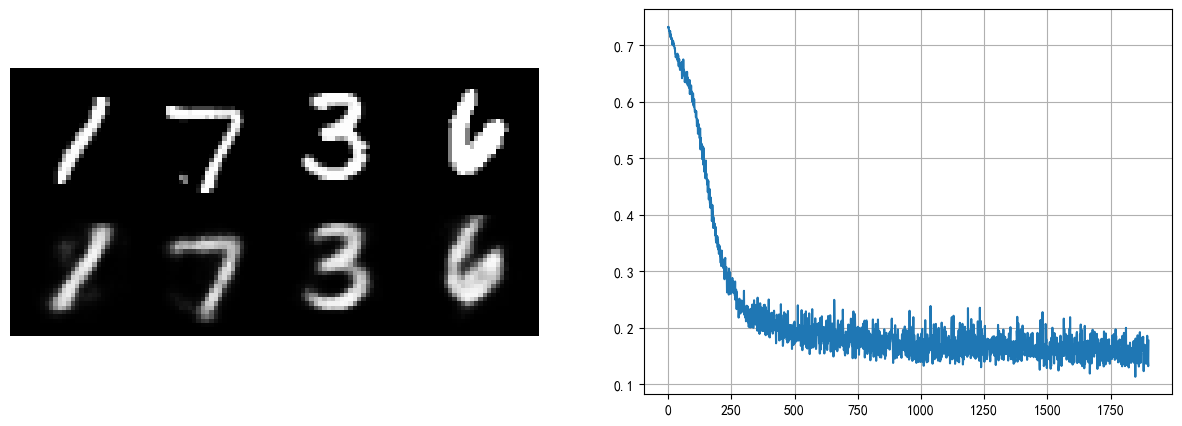

Train on 2000 steps finished.
Final loss: 0.16082371771335602


In [ ]:
# create encoder and decoder
encoder, decoder = Encoder(784, 200, 20), Decoder(20, 200, 28, 1)

# use `F.binary_cross_entropy` as loss function, learning rate = 0.0005, train steps = 6000
allImages = train(encoder, decoder, mnistTraining, mnistTest, F.binary_cross_entropy, lr=0.0005, step=2000)

---
看起来还行，你可以尝试更改中间层神经元的数量或是隐变量的维度，也可以调整学习率和训练步数，看看结果有没有变化。

## 改进自动编码器

经过初次尝试，你应该对自动编码器有了一定了解，下面，我们将改进自动编码器，尝试生成更好的图像，并探究隐变量 $\bf{z}$ 究竟拥有什么含义。

---
### 使用卷积层来搭建编码器和解码器

我们可以尝试把刚才基于线性层的编码器和解码器改成基于卷积（`nn.Conv2d`）的。

具体来说，我们不对输入进行变形操作，而直接使用它的 `[28, 28]` 矩阵，然后我们使用 `nn.Conv2d` 以及 `nn.ConvTranspose2d` 来对输入进行上采样或是下采样。

我们也可以使用 `nn.LeakyReLU` 作为激活函数，它在完成这类任务时效果更好。



基本的 `building block` 就像下面这样：

---

```
Encoder:
    nn.Conv2d(dIn, dOut, kernel, stride, padding)
    nn.LeakyReLU()
    nn.BatchNorm2d(dOut)
    ...
```
---


```
Decoder:
    nn.ConvTranspose2d(dIn, dOut, kernel, stride, padding, outputPadding)
    nn.LeakyReLU()
    nn.BatchNorm2d(dOut)
    ...
```
---

**例如，`nn.Conv2d(dIn, dOut, 3, 1, 1)` 不改变输出的尺寸，`nn.Conv2d(dIn, dOut, 3, 2, 1)` 的输出尺寸是输入的 $1 / 4$（宽，高各变为一半）。**

**`nn.ConvTranspose2d(dIn, dOut, 3, 1, 1, 0)` 不改变输出的尺寸，`nn.ConvTranspose2d(dIn, dOut, 3, 2, 1, 1)`的输出尺寸是输入的 4 倍（宽，高各变为 2 倍）。**

`Conv2d` 的输出与输入的关系是（$H$ 与 $W$ 满足同样的关系，输入为 `[N, Cin, H, W]`，输出为 `[N, Cout, H', W']`）：

$$
H' = \frac{H + 2 \times padding - (kernel - 1) - 1}{stride} + 1
$$


`ConvTranspose2d` 的输出与输入的关系是（$H$ 与 $W$ 满足同样的关系，输入为 `[N, Cin, H, W]`，输出为 `[N, Cout, H', W']`）：

$$
H' = (H - 1) \times stride - 2 \times padding + (kernel - 1) + outputPadding
$$

简单来说，`Conv2d` 与 `ConvTranspose2d` 的输入与输出尺寸互逆。

---
下面，我们建立 `ConvEncoder` 和 `ConvDecoder`。

你可以依据上面的 `Conv2d` 和 `ConvTranspose2d` 的例子，尝试把 `z` 的维度变换成 `[N, 20, 7, 7]`，再变换回 `[N, 1, 28, 28]`。

In [12]:
# Convolutional Encoder
class ConvEncoder(nn.Module):
    """ Convolutional encoder with 3 conv layers 
    Args:
            cIn (int): Channel of x.
        cHidden (int): Channel of intermediate Convs.
             cZ (int): Channel of z.
             
    Inputs:
        x (torch.FloatTensor): [N, 1, 28, 28]. Input x.
        
    Outputs:
        torch.FloatTensor: [N, cZ, 7, 7]. Latent variable z.
    """
    def __init__(self, cIn: int, cHidden: int, cZ: int):
        super().__init__()
        # Build conv network
        # every conv block looks like:
        # ###################################
        # nn.Conv2d(cIn, cOut, kernel, stride, padding),
        # nn.LeakyReLU(),
        # nn.BatchNorm2d(cOut),
        # ###################################
        # and last conv is a bare `nn.Conv2d`
        self._net = nn.Sequential(
            # nn.Conv2d(cIn, cHidden, 3, 2, 1),
            # nn.LeakyReLU(),
            # nn.BatchNorm2d(cHidden),
            # ...
            # nn.Conv2d(cHidden, cZ, 3, 1, 1)
            ###### PUT YOUR CODE HERE ######
            # [conv -> leakyrelu -> bn] * 2 -> conv
            nn.Conv2d(cIn, cHidden, 3, 2, 1), # shrink the size of image
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.Conv2d(cHidden, cHidden, 3, 2, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.Conv2d(cHidden, cZ, 3, 1, 1)
        )
        
    def forward(self, x):
        return self._net(x)

In [13]:
# Convolutional Decoder
class ConvDecoder(nn.Module):
    """ Convolutional decoder with 3 conv layers 
    Args:
             cZ (int): Channel of z.
        cHidden (int): Channel of intermediate Convs.
             cX (int): Channel of xHat.

    Inputs:
        x (torch.FloatTensor): [N, cZ, 28, 28]. Input latent variable z.
        
    Outputs:
        torch.FloatTensor: [N, cX, 28, 28]. Outpus xHat.
    """
    def __init__(self, cZ: int, cHidden: int, cX: int):
        super().__init__()
        # Build conv network
        # every conv block looks like:
        # ###################################
        # nn.ConvTranspose2d(cIn, cOut, kernel, stride, padding, outputPadding),
        # nn.LeakyReLU(),
        # nn.BatchNorm2d(cOut),
        # ###################################
        # and last conv is a bare `nn.ConvTranspose2d`
        self._net = nn.Sequential(
            # nn.ConvTranspose2d(cZ, cHidden, 3, 2, 1, 1),
            # nn.LeakyReLU(),
            # nn.BatchNorm2d(cHidden),
            # ...
            # nn.ConvTranspose2d(cHidden, cZ, 3, 1, 1, 1)
            ###### PUT YOUR CODE HERE ######
            # [conv -> leakyrelu -> bn] * 2 -> conv
            nn.ConvTranspose2d(cZ, cHidden, 3, 2, 1, 1), # expand the size of image with 2 times
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.ConvTranspose2d(cHidden, cHidden, 3, 2, 1, 1), # expand the size of image with 2 times
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.ConvTranspose2d(cHidden, cX, 3, 1, 1, 0), # keep the shape
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self._net(x)

---
再次检查隐变量和输出的形状是否符合规则。


## 请注意

下面所有代码中的 `cHidden, cZ, k` 等等变量需要你自己填写一个合适的值进去。如：`cHidden` 改成 `200`。

In [14]:
cHidden = 200
cZ = 20

convEncoder = ConvEncoder(1, cHidden, cZ)
x = torch.rand(5, 1, 28, 28)
z = convEncoder(x)
print("Shape of \"z\":", list(z.shape))

convDecoder = ConvDecoder(cZ, cHidden, 1)
xHat = convDecoder(z)
print("Shape of \"xHat\":", list(xHat.shape))
if xHat.shape != x.shape:
    raise ValueError("Oops! x and xHat don't have same shape")
else:
    print("Alright!")

Shape of "z": [5, 20, 7, 7]
Shape of "xHat": [5, 1, 28, 28]
Alright!


没有报错！我们就可以用这个新的自动编码器来试试效果了。

### **请注意**

使用卷积网络的时候，速度会变得很慢，请尝试少用几层卷积层或者减小 kernel size。

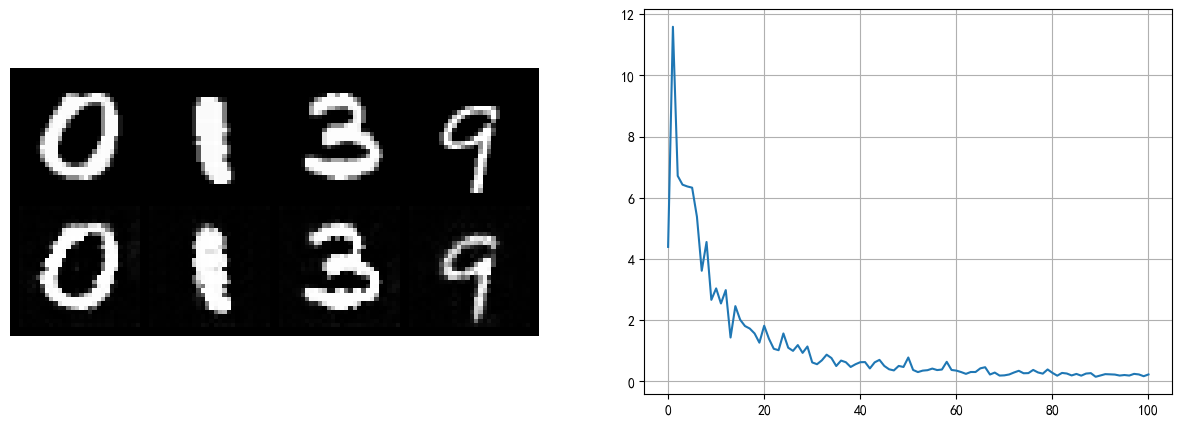

KeyboardInterrupt: 

In [15]:
convEncoder, convDecoder = ConvEncoder(1, cHidden, cZ), ConvDecoder(cZ, cHidden, 1)

train(convEncoder, convDecoder, mnistTraining, mnistTest, F.binary_cross_entropy, lr=0.001, step=1000)

---
### 换用其它损失函数

我们也可以尝试用**均方误差**当作损失函数。

**均方误差**就是计算**输出**和**输入**之间的欧式距离，让输出和输入越接近越好。

In [ ]:
lossFn = F.mse_loss

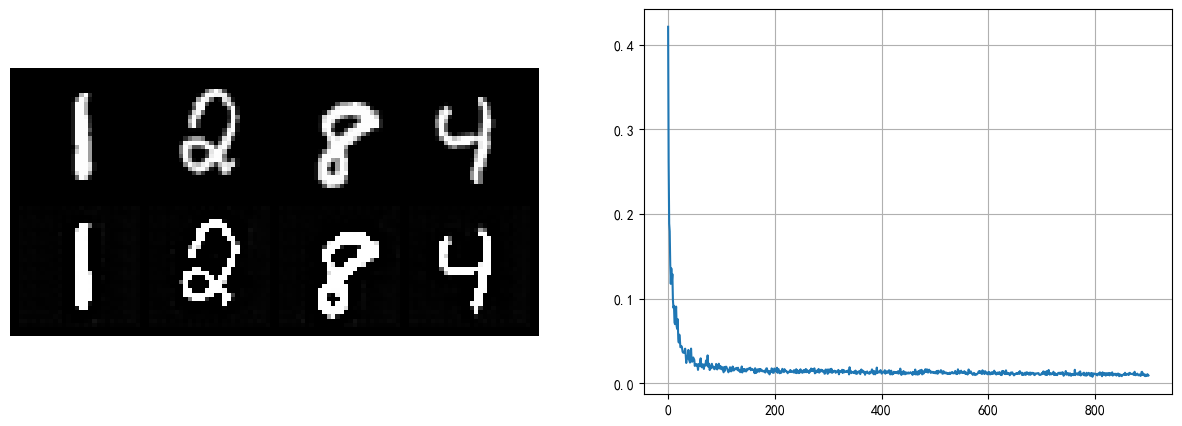

Train on 1000 steps finished.
Final loss: 0.012190576642751694


[tensor([[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.4075, 0.4075, 0.4075],
          ...,
          [0.4111, 0.4111, 0.4111],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

In [ ]:
convEncoder, convDecoder = ConvEncoder(1, cHidden, cZ), ConvDecoder(cZ, cHidden, 1)

train(convEncoder, convDecoder, mnistTraining, mnistTest, F.mse_loss, lr=0.001, step=1000)

当然，你也可以尝试 `F.l1_loss`，`F.smooth_l1_loss` 等其他的损失函数，看看哪种效果最好。

---
# 作业

现在，你已经了解了如何构造一个自动编码器并对图像进行自动编码。下面，我们尝试更难的数据——**CIFAR-10**。


**CIFAR-10** 数据集共有 $60,000$ 张彩色图像，分辨率为 $32 \times 32$，分为 $10$ 个类，每类 $6,000$ 张图。其中有 $50,000$ 张用于训练，另外 $10,000$ 用于测试。

下面这幅图就列举了这10个分类，每一类展示了随机的10张图片：



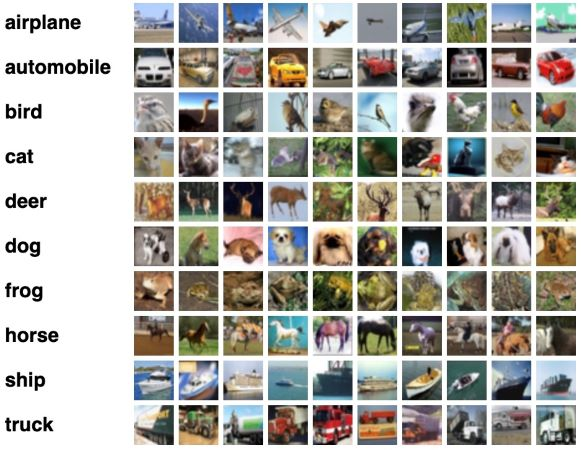

---
使用 `CIFAR-10` 的方法和使用 `MNIST` 的方法大同小异。我们还是为你提供了数据读取和预处理的相关代码。

In [ ]:
cifarTrainingTransforms = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip()
])

cifarTraining = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=cifarTrainingTransforms)
cifarTest     = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=T.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


下面，请你写出用于 `CIFAR-10` 的自动编码器（可以使用上述任意方式和任意损失函数），然后尝试训练得到最好的结果。

### **请注意**

现在的 `CIFAR-10` 数据，输入维度是 `[N, 3, 32, 32]`。

你可以自己设计网络结构（使用卷积层，建议不用全连接层），隐变量维度自定，完成以下代码。

In [ ]:
class CifarEncoder(nn.Module):
    """ Cifar encoder
    Args:
            cIn (int): Channel of x.
        cHidden (int): Channel of intermediate Convs.
             cZ (int): Channel of z.
             
    Inputs:
        x (torch.FloatTensor): [N, cIn, 32, 32]. Input x.
        
    Outputs:
        torch.FloatTensor: [N, cZ, ?, ?]. Latent variable z.
    """
    def __init__(self, cIn: int, cHidden: int, cZ: int):
        super().__init__()
        self._net = nn.Sequential(
            ###### PUT YOUR CODE HERE ######
            # [conv -> leakyrelu -> bn] * 2 -> conv
            nn.Conv2d(cIn, cHidden, 3, 2, 1), # shrink the size of image
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.Conv2d(cHidden, cHidden, 3, 2, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.Conv2d(cHidden, cZ, 3, 1, 1)
        )
        
    def forward(self, x):
        return self._net(x)

In [ ]:
class CifarDecoder(nn.Module):
    """ Cifar decoder
    Args:
             cZ (int): Channel of z.
        cHidden (int): Channel of intermediate Convs.
             cX (int): Channel of xHat.
             
    Inputs:
        x (torch.FloatTensor): [N, C, ?, ?]. Input latent variable z.
        
    Outputs:
        torch.FloatTensor: [N, cX, 32, 32]. xHat.
    """
    def __init__(self, cZ: int, cHidden: int, cX: int):
        super().__init__()
        self._net = nn.Sequential(
            ###### PUT YOUR CODE HERE ######
            # [conv -> leakyrelu -> bn] * 2 -> conv
            nn.ConvTranspose2d(cZ, cHidden, 3, 2, 1, 1), # expand the size of image with 2 times
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.ConvTranspose2d(cHidden, cHidden, 3, 2, 1, 1), # expand the size of image with 2 times
            nn.LeakyReLU(),
            nn.BatchNorm2d(cHidden),
            nn.ConvTranspose2d(cHidden, cX, 3, 1, 1, 0), # keep the shape
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self._net(x)

In [ ]:
cHidden = 6
cZ = 20

convEncoder = CifarEncoder(3, cHidden, cZ)
x = torch.rand(5, 3, 32, 32)
z = convEncoder(x)
print("Shape of \"z\":", list(z.shape))

convDecoder = CifarDecoder(cZ, cHidden, 3)
xHat = convDecoder(z)
print("Shape of \"xHat\":", list(xHat.shape))
if xHat.shape != x.shape:
    raise ValueError("Oops! x and xHat don't have same shape")
else:
    print("Alright!")

Shape of "z": [5, 20, 8, 8]
Shape of "xHat": [5, 3, 32, 32]
Alright!


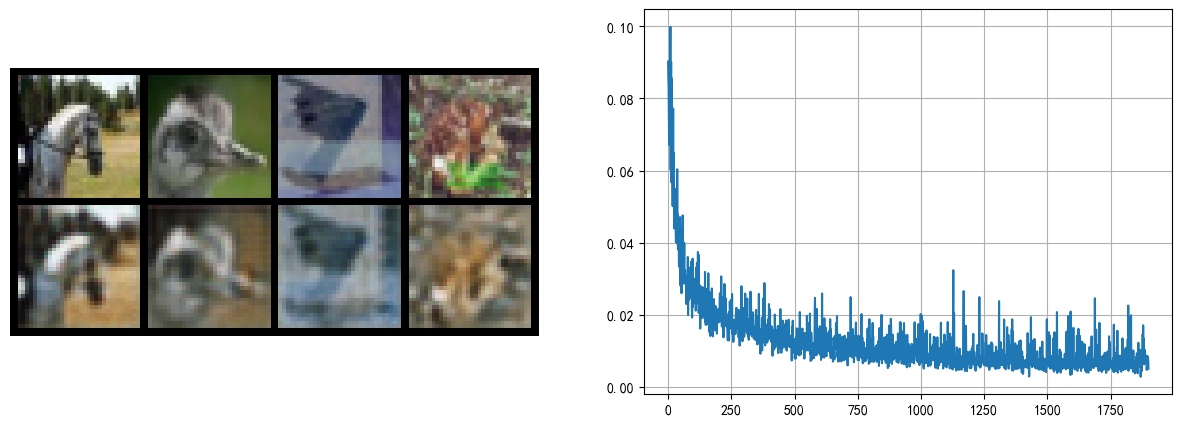

Train on 2000 steps finished.
Final loss: 0.004672347102314234


[tensor([[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.3294, 0.2549, 0.2078],
          ...,
          [0.5608, 0.5020, 0.4510],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.4621, 0.5158, 0.4712],
          ...,
          [0.4590, 0.5087, 0.4660],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

In [ ]:
# cHidden, cZ needs customize
cifarEncoder, cifarDecoder = CifarEncoder(3, cHidden, cZ), CifarDecoder(cZ, cHidden, 3)
# use which loss? lr? how many steps?
train(cifarEncoder, cifarDecoder, cifarTraining, cifarTest, F.mse_loss, lr=0.0005, step=2000)

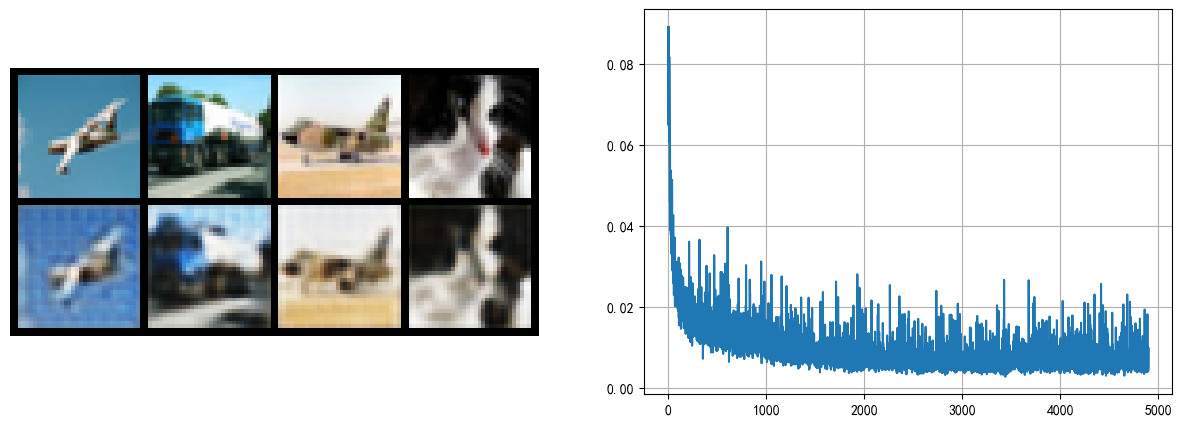

Train on 5000 steps finished.
Final loss: 0.004130666609853506


[tensor([[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.1961, 0.4667, 0.5961],
          ...,
          [0.0353, 0.0353, 0.0353],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.4615, 0.5184, 0.4689],
          ...,
          [0.4504, 0.5239, 0.4685],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

In [ ]:
# cHidden, cZ needs customize
cifarEncoder, cifarDecoder = CifarEncoder(3, cHidden, cZ), CifarDecoder(cZ, cHidden, 3)
# use which loss? lr? how many steps?
train(cifarEncoder, cifarDecoder, cifarTraining, cifarTest, F.mse_loss, lr=0.0005, step=5000)

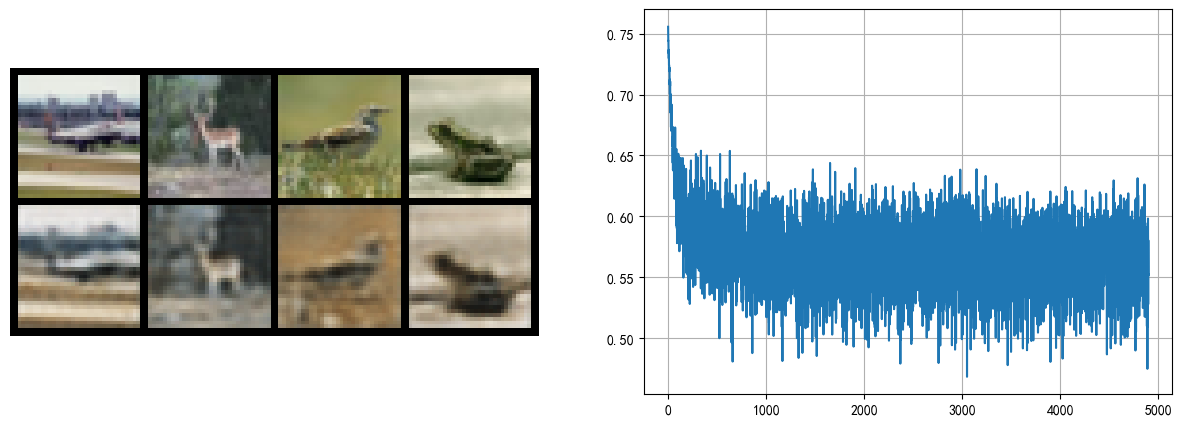

Train on 5000 steps finished.
Final loss: 0.5496854186058044


[tensor([[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.9137, 0.9333, 0.9098],
          ...,
          [0.8196, 0.8039, 0.7059],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.5412, 0.4746, 0.4736],
          ...,
          [0.5396, 0.4752, 0.4712],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

In [ ]:
# cHidden, cZ needs customize
cifarEncoder, cifarDecoder = CifarEncoder(3, cHidden, cZ), CifarDecoder(cZ, cHidden, 3)
# use which loss? lr? how many steps?
train(cifarEncoder, cifarDecoder, cifarTraining, cifarTest, F.binary_cross_entropy, lr=0.0005, step=5000)

---
## **请注意保存以上所有的结果输出。**

In [ ]:
# clean up
del convEncoder, convDecoder, cifarEncoder, cifarDecoder

# 扩展实验

# Ⅰ. 隐变量的可视化

你也许已经发现，现在的输出数据已经能够很好地还原原始数据了。其中充当中介作用的是**隐变量** $\bf{z}$。

相对于原始数据来说，$\bf{z}$ 通常维度更小，意味着自动编码器把数据做了降维压缩。

同时，自动编码器能够学习输入数据的隐含分布，并通过 $\bf{z}$ 表现出来。

下面，我们尝试对 `MNIST` 的隐变量进行可视化，看看 $\bf{z}$ 到底表现如何。

在跑可视化之前，请先训练 `Encoder` 和 `Decoder`。（ “[训练过程](#训练过程)” 一节）

In [ ]:
from sklearn.manifold import TSNE

# use t-SNE to reduce dim to 2D for plotting in 2D axes
def tsne(latents):
    return TSNE().fit_transform(latents)

# pick all latents and corresponding labels
@torch.no_grad()
def collectLatent(encoder: nn.Module, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    
    latents = list()
    labels = list()
    
    ###### PUT YOUR CODE HERE #########
    for image, label in loader:
        # get z ([N, 20]) from encoder
        latent = encoder(image)
        print(latent.shape)
        # append to latents
        latents.append(latent)
        # append label to labels
        labels.append(label)
        
    ###### PUT YOUR CODE ABOVE ########
    
    # latents: list of [N, 20], labels: list of [N]
    return torch.cat(latents, 0).numpy(), torch.cat(labels, 0).numpy()

# plot latents in 2D figure
def visualizeLatent(latents, labels):
    # [N, 2]
    reduced = tsne(latents)
    fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
    plt.axis("off")
    # plot reduced-latent on figure and colored by labels
    plt.scatter(reduced[:, 0], reduced[:, 1], s=4, c=labels)

Computing tSNE......
This is slow......


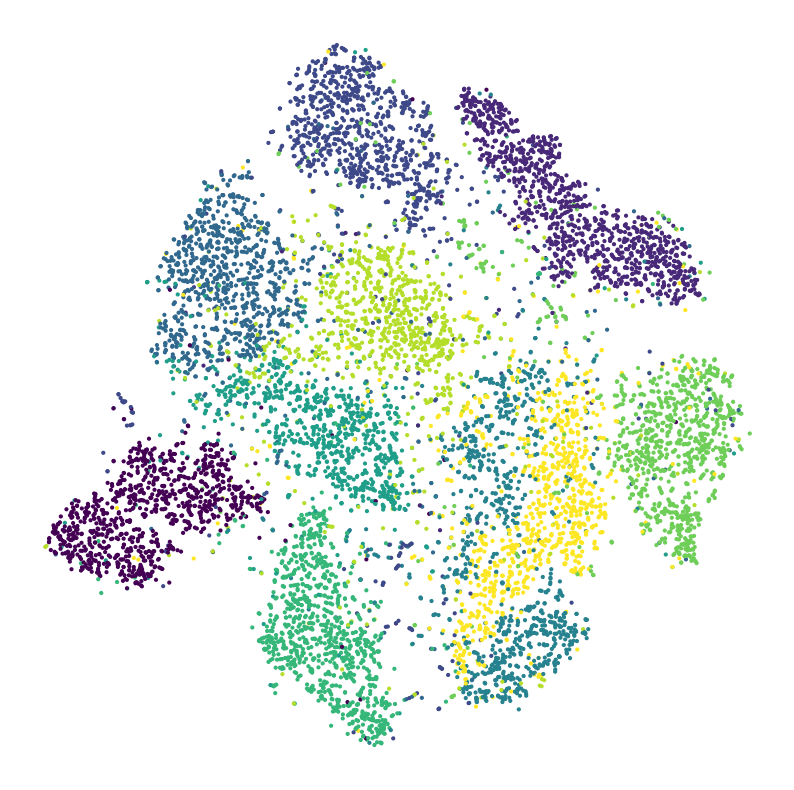

In [ ]:
print("Collecting latent......")
latents, labels = collectLatent(encoder, mnistTest)
print("Computing tSNE......")
print("This is slow......")
visualizeLatent(latents, labels)

完美！

既然 $\bf{z}$ 在所谓的 “隐变量空间” 中聚集成簇，那我们也许可以尝试把各个簇的簇中心输入到解码器中试一试……

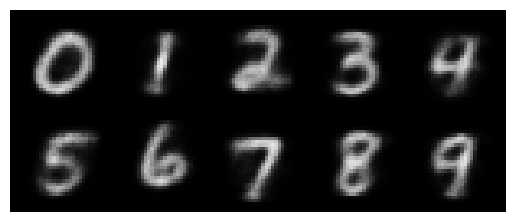

In [ ]:
decoder.eval()
meanImages = list()

# 10 label
for i in range(10):
    # pick all latents that corresponding to label i
    latentOfThisLabel = latents[labels == i]
    # calulate these latents' mean embedding
    meanLatent = np.mean(latentOfThisLabel, 0, keepdims=True)
    # feed into decoder
    meanXHat = decoder(torch.from_numpy(meanLatent))
    meanImages.append(meanXHat)

# plot
meanImages = torch.cat(meanImages, 0)
results = torchvision.utils.make_grid(meanImages, nrow=5)
plt.axis("off")
plt.imshow(results.permute(1, 2, 0))
plt.show()



# Ⅱ. 变分自编码器

观察上面的可视化图形，也许你会猜想：**隐变量 $\bf{z}$ 有没有可能满足正态分布？**

基于这种假设，人们设计出了**变分自编码器**。

与上面的普通自编码器不同，因为数据集可以看作一个大的集合 $\bf{X} = \{ \bf{x}_1, \cdots, \bf{x}_n \}$，这个集合中的 $\bf{x} \in \bf{X}$ 天然满足某种分布。

那自然地，如果我们假设 $\bf{z} \in \bf{Z}$ 满足正态分布，那么，这个正态分布的**均值 $\mu$**，**方差 $\sigma$** 就是**充分统计量**。编码器确定了 $\bf{z} \in \bf{Z}$ 分布的**均值**和**方差**，就相当于已知了 $\bf{Z}$。

已知 $\bf{Z}$ 的分布以后，我们甚至不需要输入一个具体的 $\bf{x}$，只需从 $\bf{Z}$ 的分布中采样出一个 $\bf{z}$，交给解码器，就能够得到一个伪造的 $\hat{\bf{x}}$。

那么，如果我们的自动编码器能够根据整个数据集 $\bf{x} \in \bf{X}$ 的输入，去刻画这样的一个正态分布，即后验分布 $p\left(\bf{Z} \mid \bf{X}\right)$，那么我们就能够*完全掌控*输入与输出了。

这就是**变分自编码器**的基本概念。其中：

- $E$：用于建模后验概率 $p\left(\bf{Z} \mid \bf{X}\right)$；
- $D$：基于后验概率重建 $\bf{x}$。

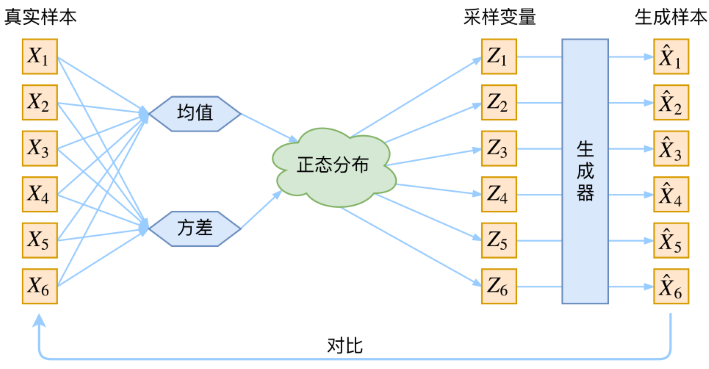

---

当然，上述概念为了方便理解，还不严谨，想要更加深入理解变分自编码器，可以参阅网上资料。

参考资料：
- [【学习笔记】生成模型——变分自编码器](http://www.gwylab.com/note-vae.html)
- [李宏毅 Machine Learning，Lecture 21](https://www.bilibili.com/video/av15889450/?p=33)

下面，我们来尝试实现一个变分自编码器（`VAE`）。

与上面最基本的概念相比稍微复杂，我们希望编码器生成 `2*K` 个值，表示 `K` 元的高斯混合分布的均值和方差，用以建模 $p\left(\bf{Z} \mid \bf{X}\right)$。

之后，我们通过在这个 `K` 元高斯混合分布中采样得到 $\bf{z}$（`K` 个实数值组成的向量），送给解码器，用以还原 $\bf{x}$。

设计 Encoder 时的主要思路是跟前面的编码器差不多，你可以使用 `nn.Linear` 或者 `nn.Conv2d`。你可以使用 `nn.Flatten` 来把 `[N, C, H, W]` 的特征变成 `[N, C*H*W]` 的二维矩阵。

In [ ]:
class VAEEncoder(nn.Module):
    """ VAE encoder
    Args:
            cIn (int): Channel of x.
        cHidden (int): Channel of intermediate Convs.
              k (int): Final output, K-dim GMM.
             
    Inputs:
        x (torch.FloatTensor): [N, cIn, 28, 28]. Input x.
        
    Outputs:
        torch.FloatTensor: [N, 2, k]. k-(mean and variance)s of GMM.
    """
    def __init__(self, cIn: int, cHidden: int, k: int):
        super().__init__()
        self._net = nn.Sequential(
            ###### PUT YOUR CODE HERE ######
            YOU_NEED_IMPLEMENT()
        )
        
    def forward(self, x):
        # x: [N, 1, 28, 28] -> [N, hidden, 7, 7] -> [N, 2 * k]
        # return [N, 2, k]
        return self._net(x).reshape(x.shape[0], 2, -1)
    
class VAEDecoder(nn.Module):
    """ VAE decoder
    Args:
            k (int): k-dim GMM.
        cHidden (int): Channel of intermediate Convs.
             cX (int): Channel of xHat.
             
    Inputs:
        z (torch.FloatTensor): [N, k]. k samples from the k-dim GMM.
        
    Outputs:
        torch.FloatTensor: [N, cX, 28, 28]. xHat.
    """
    def __init__(self, k: int, cHidden: int, cX: int):
        super().__init__()
        self._net = nn.Sequential(
            ###### PUT YOUR CODE HERE ######
            YOU_NEED_IMPLEMENT()
            nn.Sigmoid()
        )
        
    def forward(self, z):
        return self._net(z)

从 `VAEEncoder` 得到 `K` 组均值和方差了以后，怎么得到正态分布呢？我们可以借助 [`torch.distributions.Normal`](https://pytorch.org/docs/stable/distributions.html#normal)。由于方差必须大于 $0$，我们对 `VAEEncoder` 输出的方差再使用 `softplus` 函数从 $\left(-\infty, +\infty\right)$ 转换到 $\left(0, +\infty\right)$ 上。

In [ ]:
from torch.distributions import Normal, kl_divergence

In [ ]:
vaeEncoder = VAEEncoder(1, cHidden, k)

x = torch.rand(5, 1, 28, 28)

# [N, 2, k]
meanAndStd = vaeEncoder(x)

# Use torch.distributions.Normal
# Normal(mean, std) -> create a k-dim normal distribution
# mean <- meanAndStd[:, 0]
# std <- meanAndStd[:, 1]
variationalPosterior = Normal(meanAndStd[:, 0], F.softplus(meanAndStd[:, 1]) + 1e-6)

print("Sample shape:", list(variationalPosterior.rsample().shape))

上面的代码中，我们把这个通过 `meanAndStd` 定义的分布叫做**变分后验分布（Variational Posterior）**。

我们使用 `Normal(meanAndStd[:, 0], F.softplus(meanAndStd[:, 1]) + 1e-6)` 定义了一个**10 维高斯混合分布**。

我们就在 `batch size = 5` 的 10 维高斯混合分布中进行了一次采样，样本的形状为：`[5, 10]`。

这里要注意，我们使用了 `variationalPosterior.rsample()` 这个函数，进行的是**重参数化采样**，为的是让这个随机的采样变得可以求导。

In [ ]:
vaeDecoder = VAEDecoder(k, cHidden, 1)

sample = variationalPosterior.rsample()

xHat = vaeDecoder(sample)

print("Shape of \"xHat\":", list(xHat.shape))

---
接下来就是 VAE 的训练过程了。与普通的自动编码器稍有不同， VAE 的训练遵循以下范式：

1. 输入 $\bf{x}$，通过 $E$ 建模变分后验分布 $p\left(\bf{z} \mid \bf{x} \right)$
2. 从变分后验分布中采样一个 $\bf{z}$
3. 把采样得到的 $\bf{z}$ 输入 $D$，得到 $\hat{\bf{x}}$。

训练时，除了自动编码器必需的重构损失外，我们还希望 **变分后验分布** 与 **先验分布** 尽可能接近。这样我们就能够更好的依据先验分布刻画变分后验分布。

如何促使两个分布接近呢？一个最常用的度量方法是 KL 散度。我们借助 `torch.distributions.kl_divergence` 来建立损失函数，与重构损失一块训练网络。扩展阅读：

- [相对熵](https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%AF%B9%E7%86%B5)
- [为什么统计学习算法中常讨论 KL 距离?](https://www.zhihu.com/question/29980971)

在这个实验中，我们已经把变分后验分布建模为一个混合高斯分布（编码器 $E$ 预测 `K` 个高斯分布的均值和方差）。通常，我们规定先验分布为标准正态分布（这 `K` 个高斯分布的均值为 `0`，方差为 `1`）。你需要实现下面代码的 `44, 46, 48, 50` 行，通过 KL 散度将两个分布对齐。

In [ ]:
def trainVAE(vaeEncoder: nn.Module, vaeDecoder: nn.Module, trainDataset, testDataset, lossFn, lr = 0.001, step = 1000):
    def visualizeVAE(vaeEncoder: nn.Module, vaeDecoder: nn.Module, testImages: torch.Tensor, losses: [float]):
        display.clear_output(wait=True)

        meanAndStd = vaeEncoder(testImages)
        variationalPosterior = Normal(meanAndStd[:, 0], F.softplus(meanAndStd[:, 1]) + 1e-6)
        sample = variationalPosterior.rsample()

        xHat = vaeDecoder(sample)

        results = torch.cat([testImages, xHat], 0)
        results = torchvision.utils.make_grid(results, nrow=4)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.axis("off")
        ax1.imshow(results.permute(1, 2, 0))

        ax2.plot(losses)
        ax2.grid(True)
        plt.show()
    
    loader = torch.utils.data.DataLoader(trainDataset, batch_size=8, shuffle=True, num_workers=2)
    
    optimizer = torch.optim.Adam(list(vaeEncoder.parameters()) + list(vaeDecoder.parameters()), lr)
    
    testImgs = list()
    pick = random.sample(range(len(testDataset)), 4)
    for i in pick:
        testImgs.append(testDataset[i][0])
    testImgs = torch.stack(testImgs, 0)
    
    losses = list()

    iterator = iter(loader)
    
    for i in range(step):
        try:
            x, _ = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            x, _ = next(iterator)
        # ###########################################
        # ############### VAE TRAINING ##############
        # ###########################################
        # predict k means and stds from encoder(x)
        meanAndStd = YOU_NEED_IMPLEMENT()
        # estimate variational posterior by mean and std
        variationalPosterior = YOU_NEED_IMPLEMENT()
        # prior (k-dim Normal) with mean=0, std=1
        prior = YOU_NEED_IMPLEMENT()
        # align variational posterior to prior
        klLoss = YOU_NEED_IMPLEMENT()
        # sample from variational posterior
        sample = variationalPosterior.rsample()
        # reconstruct xHat by decoder(sample)
        xHat = YOU_NEED_IMPLEMENT()

        loss = lossFn(xHat, x)
        # reconstruction loss + kl loss
        loss = loss + 0.1 * klLoss

        losses.append(loss.item())

        optimizer.zero_grad(None)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            torch.set_grad_enabled(False)
            vaeEncoder.eval()
            vaeDecoder.eval()
            visualizeVAE(vaeEncoder, vaeDecoder, testImgs, losses)
            vaeEncoder.train()
            vaeDecoder.train()
            torch.set_grad_enabled(True)
    print(f"Train on {step} steps finished.")
    print(f"Final loss: {loss.item()}")
    return


In [ ]:
vaeEncoder, vaeDecoder = VAEEncoder(1, cHidden, k), VAEDecoder(k, cHidden, 1)

trainVAE(vaeEncoder, vaeDecoder, mnistTraining, mnistTest, F.binary_cross_entropy, lr=0.0005, step=2000)

你也许会发现，在训练过程中，输出的图像并不那么 “稳定”，数字一会像是 `2`,一会像是 `8`，一会又像 `3`。这正是因为在训练中我们是从正态分布中**采样**出 $\bf{z}$ 来进行解码，采样出的隐变量具有随机性，导致解码器输出的数字也会跳动。

---
训练完成之后，我们就可以来试一试生成 “伪造数字” 了！

既然 $\bf{z}$ 通过采样得来，同时我们已经促使我们的 $\bf{z}$ 所处的分布为 `K` 个标准正态分布的混合。因此，我们直接从标准正态分布中随机采样 `K` 个值，就能当作 $\bf{z}$ 输入解码器了。

In [ ]:
z = Normal(0.0, 1.0).sample((5, 16))


xHat = vaeDecoder(z)

results = torchvision.utils.make_grid(xHat, nrow=5)

plt.imshow(results.permute(1, 2, 0))
plt.axis("off")
plt.show()

完美！现在，你已经了解了变分自编码器的基本工作原理了。

# Ⅲ. 生成对抗网络

生成对抗网络的结构更加有趣，**生成器**和**判别器**展现了 “左右互博” 的过程。

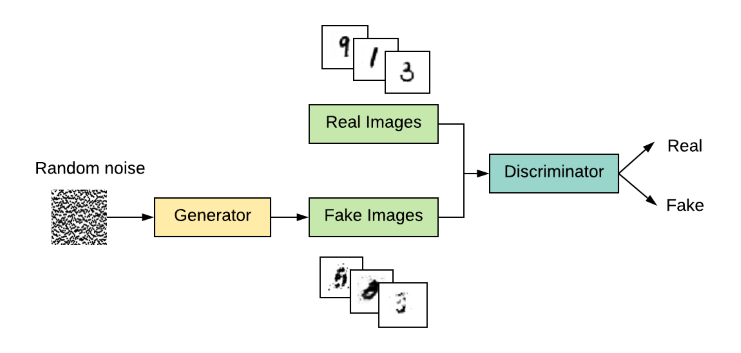

具体来说，我们的生成器也是通过从一个分布中随机采样来生成伪造图片。之所以能生成图片，正是因为之前的假设——隐变量满足一定分布。

如何让生成的图片越来越好？这就轮到判别器发挥作用了。我们把伪造的图片和真实的图片交给判别器，并训练判别器辨认哪些图片是伪造的，哪些是真实的。生成器则恰恰相反，**它根据判别器的判断来调整自己，尽可能去欺骗判别器**。

实际训练的时候，流程是这样的：

1. 根据随机噪声 $\bf{z}$，生成器 $G$ 生成一组伪造图片 $\hat{\bf{x}}$.
2. 把伪造图片 $\hat{\bf{x}}$ 和真实图片 $\bf{x}$ 交给判别器 $D$，并告诉它真实标签，训练 $D$ 进行二分类（图片是 “真” 还是 “假”？）
3. 生成器再生成一组图片 $\hat{\bf{x}}$，同样交给判别器，但这时我们训练 $G$ 去干扰 $D$ 的分类结果。

`2` 步和 `3` 步的训练刚好相反，我们如果采用了二分类损失函数 BCE 的话，第二步就是训练 $D$ **最小化** $BCE$；第三步就是训练 $G$ **最大化** $BCE$. 这就组成了一个博弈论经典问题：`MiniMax Game`。

$$
\min_{G}\max_{D} V\left(D, G\right) = \mathbb{E}_{\bf{x} \sim \bf{X}}\left[ \log{D\left(\bf{x}\right)} \right] + \mathbb{E}_{\bf{z} \sim \bf{Z}}\left[ \log{\left(1 - D\left(G\left(\bf{z}\right)\right)\right)} \right]
$$

上式中，$\bf{x}$ 是从真实数据中采样得来，我们通过极大似然估计的方法让 $D$ 尽可能分辨出输入确实是真实数据（和式的左半部分）。$\bf{z}$ 是通过先验分布中采样得到，再经由 $G$ 生成伪造数据，我们同样通过极大似然估计法**不让** $D$ 分辨出输入是伪造数据（和式的右半部分）。

---
有了上面的知识，我们就先来构造一个生成器。

生成器接受一个实数值，它是从标准正态分布（先验）中采样得来。然后，生成器基于输入生成伪造图片。

In [ ]:
class Generator(nn.Module):
    """ GAN generator
    Args:
              k (int): Number of samples from the Gaussian distribution.
        cHidden (int): Channel of intermediate Convs.
           cOut (int): Channel of xHat.
             
    Inputs:
        n (int): Batch size.
        
    Outputs:
        torch.FloatTensor: [n, cX, 28, 28]. xHat.
    """
    def __init__(self, k: int, cHidden: int, cX: int):
        super().__init__()
        self._k = k
        self._net = nn.Sequential(*[
            ###### PUT YOUR CODE HERE ######
            YOU_NEED_IMPLEMENT()
            nn.Sigmoid()
        ])
        
    def forward(self, n):
        z = Normal(0.0, 1.0).sample((n, self._k))
        return self._net(z)

In [ ]:
generator = Generator(k, cHidden, 1)

x = torch.rand(5, 1, 28, 28)

fake = generator(x.shape[0])

print("Shape of \"fake x\": ", list(fake.shape))

---
判别器接收图片输入，最后输出一个概率值（`[N, 1]`），表示对这张图片到底有多真实的置信度。

In [ ]:
class Discriminator(nn.Module):
    """ GAN discriminator
    Args:
            cIn (int): Channel of x.
        cHidden (int): Channel of intermediate Convs.
           cOut (int): Channel of xHat.
             
    Inputs:
        x (torch.FloatTensor): [N, cIn, 28, 28]. Input x.
        
    Outputs:
        torch.FloatTensor: [n, 1]. Probability of x is a real image or not.
    """
    def __init__(self, cIn: int, cHidden: int):
        super().__init__()
        self._net = nn.Sequential(*[
            ###### PUT YOUR CODE HERE ######
            YOU_NEED_IMPLEMENT()
            nn.Sigmoid()
        ])
        
    def forward(self, x):
        return self._net(x)

In [ ]:
discriminator = Discriminator(1, cHidden)

x = torch.rand(5, 1, 28, 28)

prob = discriminator(x)

print("Shape of probabilities:", list(prob.shape))

---
接下来就是训练的过程。由于两个网络是交替训练的，我们需要两个不同的优化器分别优化。

我们使用二值分类损失 BCELoss 来作为目标函数。训练 $D$ 时，最小化目标函数，训练 $G$ 时，最大化目标函数。

In [ ]:
def trainGAN(generator: nn.Module, discriminator: nn.Module, trainDataset, testDataset, lr = 0.001, step = 1000):
    def visualizeGAN(generator: nn.Module, testImages: torch.Tensor, dLosses: [float], gLosses: [float]):
        display.clear_output(wait=True)

        xHat = generator(testImages.shape[0])

        results = torch.cat([testImages, xHat], 0)
        results = torchvision.utils.make_grid(results, nrow=4)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
        ax1.imshow(results.permute(1, 2, 0))
        ax1.axis("off")

        ax2.plot(dLosses)
        ax2.grid(True)
        ax3.plot(gLosses)
        ax3.grid(True)
        plt.show()
    
    loader = torch.utils.data.DataLoader(trainDataset, batch_size=8, shuffle=True, num_workers=2)
    
    optimizerG = torch.optim.Adam(generator.parameters(), lr)
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr)
    
    testImgs = list()
    pick = random.sample(range(len(testDataset)), 4)
    for i in pick:
        testImgs.append(testDataset[i][0])
    testImgs = torch.stack(testImgs, 0)
    
    dLosses = list()
    gLosses = list()
    
    iterator = iter(loader)
    
    for i in range(step):
        try:
            x, _ = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            x, _ = next(iterator)
        # ###########################################
        # ############### GAN TRAINING ##############
        # ###########################################
        # generate a batch of fake images
        fake = generator(x.shape[0])
        # discriminating
        if i % 2 == 0:
            # put real images and fake images into a single batch
            realAndFake = torch.cat([x, fake], 0)
            # they go to discriminator together to get scores
            probs = YOU_NEED_IMPLEMENT()
            # get real scores and fake scores
            realProb, fakeProb = torch.chunk(probs, 2)
            # train discriminator, raise real score and bring down fake score
            dLoss = F.binary_cross_entropy(realProb, torch.ones_like(realProb)) + F.binary_cross_entropy(fakeProb, torch.zeros_like(fakeProb))
            dLosses.append(dLoss.item())

            optimizerD.zero_grad(None)
            dLoss.backward()
            optimizerD.step()
        # generating
        else:
            # fake images go to discriminator get fake score
            fakeProb = YOU_NEED_IMPLEMENT()
            # REVERSE the loss, RAISE fake score
            gLoss = YOU_NEED_IMPLEMENT()
            gLosses.append(gLoss.item())

            optimizerG.zero_grad(None)
            gLoss.backward()
            optimizerG.step()

        if i % 100 == 0:
            torch.set_grad_enabled(False)
            generator.eval()
            generator.eval()
            visualizeGAN(generator, testImgs, dLosses, gLosses)
            generator.train()
            generator.train()
            torch.set_grad_enabled(True)

    print(f"Train on {step} steps finished.")
    return

In [ ]:
generator, discriminator = Generator(128, 128, 1), Discriminator(1, 128)
trainGAN(generator, discriminator, mnistTraining, mnistTest, lr=0.0002, step=15000)

### 大功告成！

### 思考

你可以对上述的实验进行更多的扩展，如使用 `VAE` 或 `GAN` 在 `Cifar` 上进行实验，或是将任务扩展到文本生成甚至音频生成上面，神经网络的潜力是惊人的！

最后，请将你的结果保存，发送至助教评分，扩展实验有额外加分噢^_^